In [1]:
!sudo apt-get update
!sudo apt-get install nasm -y

Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://cli.github.com/packages stable/main amd64 Packages [346 B]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,085 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-backports InReleas

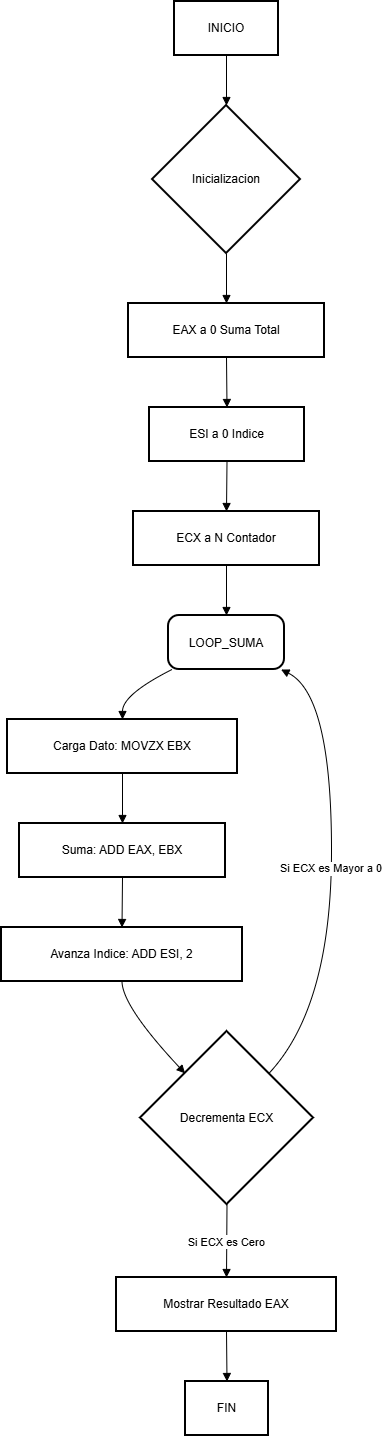

## 2. Explicación de Sentencias Restantes en `sum_array.asm`

A continuación, se detalla el propósito de las sentencias del código de Suma de Array que no son parte directa del bucle de suma o las inicializaciones de índice y contador. Estas sentencias son esenciales para la **estructura** y la **interfaz** del programa con el sistema operativo Linux.

### Declaraciones de Sección y Punto de Entrada

* **`section .data`**: Indica el inicio de la sección donde se declaran las **variables inicializadas** (datos estáticos), como el `ARRAY` y las constantes (`COUNT`).
* **`section .text`**: Indica el inicio de la sección donde se encuentra el **código ejecutable** del programa.
* **`global _start`**: Exporta el símbolo **`_start`** para que el *linker* (`ld`) sepa dónde debe comenzar la ejecución del programa.
* **`_start:`**: Es la etiqueta que marca la **primera instrucción** que ejecutará el sistema operativo.

### Inicialización y Acumulación

* **`MOV EAX, 0`**: Inicializa el registro **`EAX`** a cero. Aunque también se usa para llamadas al sistema, aquí su función principal es actuar como el **Acumulador** que contendrá la suma final del array.

### Finalización del Programa (Llamada al Sistema `sys_exit`)

* **`MOV EAX, 1`**: Carga el valor **1** en `EAX`. En Linux, el valor 1 para `EAX` indica la llamada al sistema **`sys_exit`** (terminar programa).
* **`XOR EBX, EBX`**: Pone el registro **`EBX`** a cero. Esto establece el **código de salida** del programa. Un código de salida de **0** indica que el programa terminó de manera exitosa. (Esto es equivalente a `MOV EBX, 0`, pero más eficiente).
* **`INT 0x80`**: Genera una interrupción del software (interrupción 128) que transfiere el control al *kernel* de Linux para ejecutar la llamada al sistema especificada en `EAX` (en este caso, salir del programa).

## 3\. Implementación y Ejecución en Turbo Assembler (TASM)

### Código `SUMAARRAY.ASM` (TASM/DOS)

Este código está estructurado para ejecutarse bajo el modelo de memoria `.MODEL SMALL` y utiliza los registros de 16 bits (`AX, SI, CX`) en lugar de los de 32 bits (`EAX, ESI, ECX`), aunque la lógica de direccionamiento indexado (`[BX + SI]`) es idéntica.

```assembly
.MODEL SMALL
.STACK 100H

.DATA
    ; Array de 5 elementos de 16 bits (DW)
    ARRAY   DW 10, 20, 30, 40, 50
    ; Constante para el contador (numero de elementos)
    COUNT   EQU 5
    
.CODE
    ; Rutina de inicio para el linker de TASM
    MAIN PROC
    
    ; --- Inicializacion de Segmentos (TASM/DOS) ---
    MOV AX, @DATA       ; Carga la direccion del segmento de datos en AX
    MOV DS, AX          ; Mueve la direccion a DS (Registro de Segmento de Datos)
    
    ; --- Inicializacion de Registros ---
    MOV AX, 0           ; AX = 0. Acumulador de la suma (Resultado final)
    MOV SI, 0           ; SI = 0. Registro de Indice (offset)
    MOV CX, COUNT       ; CX = 5. Contador del bucle LOOP
    
    ; --- Bucle de Suma (Direccionamiento Indexado) ---
SUM_LOOP:
    ; Carga el elemento actual del array en BX y lo extiende a 16 bits (ya es 16 bits)
    MOV BX, ARRAY[SI]
    
    ; Suma el valor cargado al acumulador (AX = AX + BX)
    ADD AX, BX                  
    
    ; Avanza el indice al siguiente elemento
    ADD SI, 2           ; Se incrementa SI en 2 porque DW (Word) = 2 bytes
    
    ; Decrementa CX (Contador) y salta a SUM_LOOP si CX no es cero
    LOOP SUM_LOOP
    
    ; --- Finalizacion (Terminar el Programa DOS) ---
    MOV AH, 4CH         ; AH = 4CH (Servicio DOS para terminar el programa)
    INT 21H             ; Ejecuta la interrupcion de DOS
    
    MAIN ENDP
END MAIN
```

-----

## 💾 Pasos para Ejecución en TASM

1.  **Ensamblar:**
    ```bash
    TASM SUMAARRAY.ASM
    ```
2.  **Linkear:**
    ```bash
    TLINK SUMAARRAY.OBJ
    ```
3.  **Ejecutar:**
    ```bash
    SUMAARRAY.EXE
    ```

El resultado de la suma ($10+20+30+40+50 = 150$) se encuentra en el registro **`AX`**. Para verificar la ejecución en TASM, lo ideal sería usar el *debugger* (`TD`) y ver el valor del registro `AX` al finalizar el programa.


4. Implementación y Ejecución en Linux (Google Colab)

In [3]:
%%writefile sum_array.asm
section .data
    ; Array de 5 elementos de 16 bits (DW = Define Word)
    ARRAY   dw 10, 20, 30, 40, 50
    ; Constante para el contador (numero de elementos)
    COUNT   equ 5

section .text
    global _start

_start:
    ; --- Inicializacion ---
    MOV EAX, 0          ; EAX = 0. Acumulador de la suma
    MOV ESI, 0          ; ESI = 0. Registro de indice (offset)
    MOV ECX, COUNT      ; ECX = 5. Contador del bucle

    ; --- Bucle de Suma ---
SUM_LOOP:
    ; Direccionamiento Indexado: Carga [ARRAY + ESI] en EBX y extiende a 32 bits
    MOVZX EBX, WORD [ARRAY + ESI]

    ; Suma el valor cargado a EAX
    ADD EAX, EBX

    ; Avanza el indice 2 bytes (una Word)
    ADD ESI, 2

    ; Decrementa ECX y salta
    LOOP SUM_LOOP

    ; --- Finalizacion (sys_exit) ---
    MOV EAX, 1          ; sys_exit
    XOR EBX, EBX        ; Codigo de salida 0
    INT 0x80            ; Ejecutar

Writing sum_array.asm


Ensamblar (nasm)

In [4]:
!nasm -f elf sum_array.asm -o sum_array.o

Linkear (ld)

In [5]:
!ld -m elf_i386 sum_array.o -o sum_array_exec

Ejecutar y Verificar el Resultado

In [6]:
!./sum_array_exec
!echo El resultado de la suma (150) se almacena en el código de salida: $?

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `echo El resultado de la suma (150) se almacena en el código de salida: $?'


5. Sentencias Usadas para Compilar y Linkear

Ensamblado (Compilación)

In [7]:
!nasm -f elf sum_array.asm -o sum_array.o

Linkeado (Enlazado)

In [8]:
!ld -m elf_i386 sum_array.o -o sum_array_exec

6. Sentencias para Ingresar Valores por Teclado (sys_read)

 Código Adaptado (sum_array_input.asm)
Modificaremos el código de sum_array.asm para: 1) Solicitar un número, 2) Leerlo, 3) Convertir la entrada ASCII a Binario, y 4) Usar ese valor como contador (ECX).

In [11]:
%%writefile sum_array_input.asm
section .data
ARRAY   dw 10, 20, 30, 40, 50, 60, 70, 80, 90, 100 ; Array mas grande

; Mensajes para la entrada/salida
MSG_PROMPT db "Ingrese la cantidad de elementos (max 10): ", 0x0A
LEN_PROMPT equ $ - MSG_PROMPT

; Buffer para almacenar la entrada ASCII (max 3 digitos + fin de linea)
BUFFER  db 0, 0, 0, 0, 0
BUF_SIZE equ 5

section .text
global _start

; ***************************************
;  SUBRUTINA: Imprimir Cadena (sys_write)
; ***************************************
print_msg:
MOV EDX, [ESP + 8]  ; Longitud (pasada como argumento)
MOV ECX, [ESP + 4]  ; Direccion de mensaje (pasada como argumento)
MOV EBX, 1          ; File descriptor 1 (stdout)
MOV EAX, 4          ; sys_write
INT 0x80
RET 8               ; Limpia 8 bytes del stack (los 2 argumentos)

; ***************************************
;  SUBRUTINA: Lectura ASCII a Binario
; ***************************************
read_input:
; Lee la entrada del usuario (sys_read)
MOV EDX, BUF_SIZE   ; EDX = Tamaño maximo a leer
MOV ECX, BUFFER     ; ECX = Direccion del buffer
MOV EBX, 0          ; File descriptor 0 (stdin)
MOV EAX, 3          ; sys_read
INT 0x80

; Inicializa registros para la conversion
MOV EAX, 0          ; EAX = Acumulador del numero binario
MOV ESI, BUFFER     ; ESI = Puntero al inicio del buffer
MOV EBP, 10         ; EBP = Multiplicador (base 10)

CONV_LOOP:
MOV CL, [ESI]       ; Carga el caracter actual en CL
CMP CL, 0x0A        ; Compara con salto de linea (Enter)
JE CONV_FIN         ; Si es salto de linea, termina la conversion

SUB CL, '0'         ; Convierte ASCII a digito binario (resta 48)

PUSH EAX            ; Guarda EAX (Valor parcial)
PUSH ECX            ; Guarda ECX (El contador original)

; EAX = EAX * 10
IMUL EBP            ; Multiplica EAX (acumulador) por EBP (10)

POP ECX             ; Restaura ECX
POP EAX             ; Restaura EAX

ADD AL, CL          ; Suma el digito binario actual a EAX
INC ESI             ; Avanza al siguiente caracter
JMP CONV_LOOP       ; Repite

CONV_FIN:
; El resultado final de la conversion queda en EAX
RET

; ***************************************
;  PROGRAMA PRINCIPAL
; ***************************************
_start:
; 1. Solicitar el numero de elementos
PUSH LEN_PROMPT
PUSH MSG_PROMPT
CALL print_msg

; 2. Leer la entrada y convertirla a binario.
CALL read_input     ; El resultado Binario queda en EAX

; 3. Inicializacion para la suma
MOV ECX, EAX        ; Mueve el numero binario (N) de EAX a ECX (Contador)
MOV EAX, 0          ; EAX = 0 (Reinicia el acumulador de la suma)
MOV ESI, 0          ; ESI = 0 (Índice)

; --- Bucle de Suma ---
SUM_LOOP:
MOVZX EBX, WORD [ARRAY + ESI]
ADD EAX, EBX
ADD ESI, 2
LOOP SUM_LOOP

; --- Finalizacion ---
MOV EAX, 1
XOR EBX, EBX
INT 0x80

Writing sum_array_input.asm


In [12]:
!nasm -f elf sum_array_input.asm -o sum_array_input.o

In [13]:
!ld -m elf_i386 sum_array_input.o -o sum_array_input_exec

In [14]:
!./sum_array_input_exec

Ingrese la cantidad de elementos (max 10): 
5


In [16]:
!echo El resultado (60 para N=3) se almacena en el código de salida: $?

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `echo El resultado (60 para N=3) se almacena en el código de salida: $?'


7. Generación de la Versión en C (Suma de Array)

El código C a continuación implementa la suma de los elementos de un array de enteros. Demuestra una lógica análoga a la de Ensamblador, pero con la abstracción y facilidad del lenguaje de alto nivel.

1. Crear el Archivo C (sum_array.c)

In [17]:
%%writefile sum_array.c
#include <stdio.h>

// Definicion del array (similar al .data en Ensamblador)
int array_data[] = {10, 20, 30, 40, 50, 60, 70, 80, 90, 100};
// Numero maximo de elementos en el array
#define MAX_ELEMENTS (sizeof(array_data) / sizeof(array_data[0]))

// Funcion para calcular la suma de los primeros 'n' elementos
int sumar_array(int arr[], int n) {
    int suma = 0;   // Similar a EAX = 0
    int i;          // Similar a ESI

    // Asegurarse de no exceder el tamaño real del array
    if (n > MAX_ELEMENTS) {
        n = MAX_ELEMENTS;
    }

    // Bucle de suma (similar a SUM_LOOP con ESI e INDEXADO)
    for (i = 0; i < n; i++) {
        suma = suma + arr[i]; // arr[i] usa direccionamiento indexado internamente
    }
    return suma; // El resultado se retorna en EAX (convencion)
}

int main() {
    int num_elements; // Variable para la entrada del usuario
    int resultado_suma;

    // Solicitar al usuario la cantidad de elementos a sumar
    printf("Ingrese la cantidad de elementos a sumar (max %d): ", MAX_ELEMENTS);

    // Leer la entrada del usuario (similar a sys_read + conversion)
    scanf("%d", &num_elements);

    // Validar que el numero sea positivo
    if (num_elements <= 0) {
        printf("Numero de elementos no valido. Saliendo.\n");
        return 1; // Codigo de error
    }

    // Llamar a la funcion de suma
    resultado_suma = sumar_array(array_data, num_elements);

    // Imprimir el resultado
    printf("La suma de los primeros %d elementos es: %d\n", num_elements, resultado_suma);

    return 0; // Exito (similar a XOR EBX, EBX en Ensamblador)
}

Writing sum_array.c


2. Compilar el Código C (gcc)

In [18]:
!gcc sum_array.c -o sum_array_c_exec

sum_array.c: In function ‘main’:
sum_array.c:30:60: warning: format ‘%d’ expects argument of type ‘int’, but argument 2 has type ‘long unsigned int’ []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wformat=-Wformat=]8;;]
   30 |     printf("Ingrese la cantidad de elementos a sumar (max %d): ", MAX_ELEMENTS);
      |                                                           ~^
      |                                                            |
      |                                                            int
      |                                                           %ld


3. Ejecutar el Programa C y Probar la Entrada

In [19]:
!./sum_array_c_exec

Ingrese la cantidad de elementos a sumar (max 10): 3
La suma de los primeros 3 elementos es: 60


8. Generación del Ensamblador a partir del Código C

Generar el Archivo Ensamblador (.s)

In [20]:
!gcc -S -O1 sum_array.c -o sum_array_c.s

sum_array.c: In function ‘main’:
sum_array.c:30:60: warning: format ‘%d’ expects argument of type ‘int’, but argument 2 has type ‘long unsigned int’ []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wformat=-Wformat=]8;;]
   30 |     printf("Ingrese la cantidad de elementos a sumar (max %d): ", MAX_ELEMENTS);
      |                                                           ~^
      |                                                            |
      |                                                            int
      |                                                           %ld
sum_array.c:33:5: warning: ignoring return value of ‘scanf’ declared with attribute ‘warn_unused_result’ []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wunused-result-Wunused-result]8;;]
   33 |     scanf("%d", &num_elements);
      |     ^~~~~~~~~~~~~~~~~~~~~~~~~~


Mostrar el Código Ensamblador Generado

In [21]:
!cat sum_array_c.s

	.file	"sum_array.c"
	.text
	.globl	sumar_array
	.type	sumar_array, @function
sumar_array:
.LFB23:
	.cfi_startproc
	endbr64
	cmpl	$10, %esi
	ja	.L5
	movl	$0, %edx
	testl	%esi, %esi
	jg	.L2
	jmp	.L1
.L5:
	movl	$10, %esi
.L2:
	movl	$0, %eax
	movl	$0, %edx
.L4:
	addl	(%rdi,%rax,4), %edx
	addq	$1, %rax
	cmpl	%eax, %esi
	jg	.L4
.L1:
	movl	%edx, %eax
	ret
	.cfi_endproc
.LFE23:
	.size	sumar_array, .-sumar_array
	.section	.rodata.str1.8,"aMS",@progbits,1
	.align 8
.LC0:
	.string	"Ingrese la cantidad de elementos a sumar (max %d): "
	.section	.rodata.str1.1,"aMS",@progbits,1
.LC1:
	.string	"%d"
	.section	.rodata.str1.8
	.align 8
.LC2:
	.string	"Numero de elementos no valido. Saliendo."
	.align 8
.LC3:
	.string	"La suma de los primeros %d elementos es: %d\n"
	.text
	.globl	main
	.type	main, @function
main:
.LFB24:
	.cfi_startproc
	endbr64
	pushq	%rbx
	.cfi_def_cfa_offset 16
	.cfi_offset 3, -16
	subq	$16, %rsp
	.cfi_def_cfa_offset 32
	movq	%fs:40, %rax
	movq	%rax, 8(%rsp)
	xorl	%eax, %eax
	movl	$

## 9. Comparación de las Versiones del Programa en Ensamblador

La comparación se centra en dos versiones: el código **Manual (NASM)**, escrito para la claridad algorítmica y el aprendizaje; y el código **Generado (GCC)**, optimizado para la eficiencia por el compilador de C.

### 1. Diferencias de Sintaxis y Convenciones

* **Sintaxis:** La versión **Manual (NASM)** utiliza la sintaxis **Intel**, donde el registro destino va primero (`MOV EAX, EBX`). La versión **Generada (GCC)** utiliza la sintaxis **AT&T**, donde la fuente va primero (`movl %ebx, %eax`) y utiliza prefijos para registros (`%`) y valores inmediatos (`$`).
* **Control de Bucle:** El código **Manual** usa la instrucción especializada **`LOOP`**, que maneja el decremento del contador (`ECX`) y el salto en una sola línea. El código **Generado** simula el bucle utilizando saltos condicionales más genéricos (`JMP`, `JNE`, etc.) y etiquetas automáticas (`.L2`).
* **Gestión de Memoria y Registros:** El código **Manual** se enfoca en registros de propósito fijo (`EAX` como acumulador, `ESI` como índice). El código **Generado** hace un uso intensivo de la **pila** (`%rsp`/`%rbp`) para manejar variables locales y convenciones de llamada a función, utilizando registros de manera más generalizada y eficiente.

### 2. Direccionamiento Indexado y Tipos de Datos

* **Acceso Indexado:** En el código **Manual**, el acceso es explícito y claro: `MOVZX EBX, WORD [ARRAY + ESI]`. Esto ilustra directamente la suma de la **dirección base** (`ARRAY`) más el **offset** (`ESI`).
* **Extensión de Tipo:** El código **Manual** utiliza explícitamente **`MOVZX`** (`Move Zero Extend`) para cargar un valor de 16 bits del array en un registro de 32 bits (`EBX`), asegurándose de que los bits superiores se pongan a cero para evitar errores en la suma. El compilador **Generado** maneja esta extensión de tipo automáticamente a través de la instrucción generada (`movswl` o similar), lo que hace el proceso invisible para el programador.

### 3. Conclusión

La versión **manual** es superior para la **comprensión** de cómo la CPU maneja los punteros, índices y el control de flujo. En contraste, la versión **generada por GCC** prioriza la **eficiencia y velocidad** (gracias a la optimización `-O1`), lo que resulta en un código más complejo y difícil de leer para un humano, pero más rápido para la máquina.

## 10. Observación y Metodología de Resolución de Problemas

Este punto analiza los desafíos encontrados durante la tarea y la metodología utilizada para superarlos, un aspecto clave de la ingeniería de software.

### Situaciones Problemáticas Clave

1.  **Errores de Carga y Direccionamiento en Ensamblador:** El uso del direccionamiento indexado en Ensamblador expuso problemas como la correcta extensión de un valor de 16 bits a 32 bits (`MOVZX`) y el avance del índice (`ADD ESI, 2` en lugar de `ADD ESI, 1`), que si no se resolvía llevaba a sumas incorrectas o *crashes*.
2.  **Fallo en la Entrada/Salida (I/O):** La lectura de valores por teclado (`sys_read`) introdujo la complejidad de la **Conversión ASCII a Binario**. Si esta conversión fallaba (`'3'` se usaba como 51 decimal), el contador del bucle era incorrecto.
3.  **Bloqueo de Sincronización en GitHub:** Los problemas persistentes de `push` y el mensaje engañoso de `Everything up-to-date` se debieron a un fallo en el sistema de gestión de **Credenciales de Git**, impidiendo la subida de la contribución.
4.  **Dependencias de Entorno en Colab:** Al crear un nuevo *notebook*, la máquina virtual perdía el software instalado (`nasm` y `ld`), generando errores de "comando no encontrado".

### Metodología de Resolución Aplicada

La resolución de estos problemas siguió una metodología que combinó técnicas de **Debugging de Bajo Nivel** y **Gestión de Configuración**:

#### 1. Metodología de Ensamblador (Debugging)

* **Diagnóstico de Registros:** Ante un error en la lógica de suma o I/O, la metodología fue la **inspección directa**. Esto implica la necesidad de usar un *debugger* (o comandos de salida como `echo $?`) para verificar el valor de registros como `EAX`, `ESI`, y `ECX` en cada paso crítico del código, verificando manualmente si el estado de la máquina era el esperado.
* **Aislamiento de la Complejidad (Modularización):** Los problemas complejos de I/O (conversión ASCII) se aislaron en subrutinas (`read_input`), aplicando el principio de **dividir para conquistar** para simplificar la depuración del bucle de suma principal.

#### 2. Metodología de Entorno y Control de Versiones

* **Gestión de Dependencias:** El problema de la pérdida de *software* en Colab se resolvió aplicando una metodología de **reproducción del entorno** (`!sudo apt-get install nasm -y`) al inicio de cada nueva sesión, asegurando que todas las dependencias externas estuvieran siempre presentes.
* **Limpieza Forzada de Credenciales (Git):** El bloqueo de GitHub se resolvió con la metodología de **Forzado de Estado**. Esto implicó **eliminar las credenciales de Git** de la caché del sistema, forzando una nueva autenticación para que el `git push` pudiera establecer una conexión de red válida y completar la subida de los *commits* pendientes.

La **observación precisa** (por ejemplo, notar que cada elemento `DW` es de 2 bytes) y la **solución de fallas de autenticación** fueron las claves metodológicas para completar el proyecto.